In [1]:
from sklearn.ensemble import VotingClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import pipeline
%matplotlib inline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator

import src.utils as utils

In [2]:

#inputs is a map of format {name: input_file.csv}
# NOTE only cnn input should contain y
def construct_dataframe(inputs):
    df_X = []
    y = []
    for prefix, filename in inputs.items():
        data = pd.read_pickle(filename).drop_duplicates()

        if prefix == 'cnn':
            y = data['y']
            data_X = data.drop('y', axis=1).add_prefix(prefix + "_")
        else:
            data_X = data.add_prefix(prefix + "_")
        
        df_X.append(data_X)
    return pd.concat(df_X, axis=1, sort=False), y

def split_train_test(X,y):
    test_X = X.loc[utils.TEST_KEYS]
    train_X = X.loc[X.index.difference(utils.TEST_KEYS)]
    test_y = y.loc[utils.TEST_KEYS]
    train_y = y.loc[y.index.difference(utils.TEST_KEYS)]
    return train_X, train_y, test_X, test_y

In [3]:
'''
import pickle
d = pd.read_pickle("vbow/vbow-orb-50-ensemble-full.pkl")
d.index = d.index.str.replace(".tif", "")
pickle.dump(d, open("vbow/vbow-orb-50-ensemble-full.pkl", 'wb'))
'''

'\nimport pickle\nd = pd.read_pickle("vbow/vbow-orb-50-ensemble-full.pkl")\nd.index = d.index.str.replace(".tif", "")\npickle.dump(d, open("vbow/vbow-orb-50-ensemble-full.pkl", \'wb\'))\n'

In [4]:
input_data = {
    "cnn": "inception/data_inception_cnn_diff_reduced_dim_augmented.pkl",
    "vbow": "vbow/vbow-orb-50-ensemble-full.pkl"
}
X, y = construct_dataframe(input_data)
X, y, X_final_test,y_final_test  = split_train_test(X, y)


In [5]:
#10/3-7-14/9-22-16

In [6]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, pref):
        self.pref = pref

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        filter_cols = [col for col in X if col.startswith(self.pref)]
        return X[filter_cols]

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

cnn = pipeline.Pipeline([
    ('col_extract_cnn', ColumnExtractor("cnn_")),
    ('cnn_model', LogisticRegression(solver='lbfgs', penalty='l2', C= 0.1, multi_class="multinomial", max_iter=3000))
])

vbow = pipeline.Pipeline([
    ('col_extract_vbow', ColumnExtractor("vbow_")),
    ('vbow_model', SVC(C=10, gamma=0.001, probability=True))
])

In [8]:
eclf = VotingClassifier(estimators=[('cnn',cnn),('vbow', vbow)])

In [108]:
def train_ensemble(X, y, multiclass, cv=3, test_size=0.3):
    params = [{'voting':['soft', 'hard']}]
    m = GridSearchCV(eclf, cv=cv, param_grid = params)
    utils.do_CV(X,y, m, multi_class=multiclass, test_size=test_size)
    return m.best_estimator_

In [ ]:
params = {'lr__C': [1.0, 100.0],
      'svm__C': [2,3,4],}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)

In [9]:
m.classes_

AttributeError: 'GridSearchCV' object has no attribute 'classes_'

# Tuning hyper-parameter

Best parameters set found on development set:

{'voting': 'soft', 'weights': [4, 1]}

Grid scores on development set:

0.607 (+/-0.043) for {'voting': 'soft', 'weights': [1, 2]}
0.661 (+/-0.011) for {'voting': 'soft', 'weights': [2, 1]}
0.696 (+/-0.057) for {'voting': 'soft', 'weights': [3, 1]}
0.714 (+/-0.051) for {'voting': 'soft', 'weights': [4, 1]}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



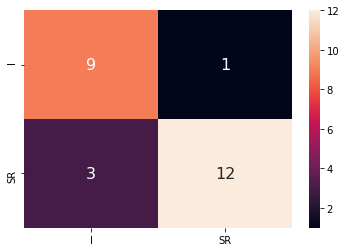

ROC AUC score
0.85


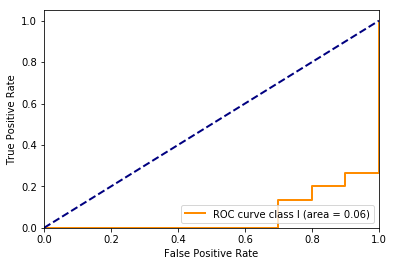


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.75      0.90      0.82        10
         SR       0.92      0.80      0.86        15

avg / total       0.85      0.84      0.84        25

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       0.91      0.91      0.91        23
         SR       0.94      0.94      0.94        33

avg / total       0.93      0.93      0.93        56



VotingClassifier(estimators=[('cnn', Pipeline(steps=[('col_extract_cnn', ColumnExtractor(pref='cnn_')), ('cnn_model', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=3000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=No...  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]))],
         n_jobs=1, voting='soft', weights=[4, 1])

In [9]:
#params = [{'voting':['soft']}, {'weights': [[1,2], [2,1], [3,1], [4,1]]}]
params = [{'voting':['soft'], 'weights': [[1,2], [2,1],[3,1], [4,1]]}]
m = GridSearchCV(eclf, cv=2, param_grid = params)
utils.do_CV(X,y, m, multi_class=False)

# Tuning hyper-parameter

Best parameters set found on development set:

{'voting': 'soft', 'weights': [2, 1]}

Grid scores on development set:

0.679 (+/-0.049) for {'voting': 'soft', 'weights': [1, 2]}
0.696 (+/-0.086) for {'voting': 'soft', 'weights': [2, 1]}
0.696 (+/-0.086) for {'voting': 'soft', 'weights': [3, 1]}
0.696 (+/-0.086) for {'voting': 'soft', 'weights': [4, 1]}
0.304 (+/-0.057) for {'voting': 'hard', 'weights': [1, 2]}
0.696 (+/-0.086) for {'voting': 'hard', 'weights': [2, 1]}
0.696 (+/-0.086) for {'voting': 'hard', 'weights': [3, 1]}
0.696 (+/-0.086) for {'voting': 'hard', 'weights': [4, 1]}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



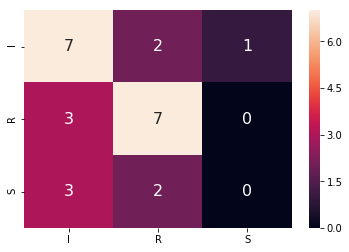

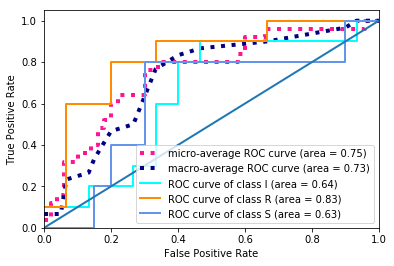


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.54      0.70      0.61        10
          R       0.64      0.70      0.67        10
          S       0.00      0.00      0.00         5

avg / total       0.47      0.56      0.51        25

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       1.00      1.00      1.00        23
          R       1.00      1.00      1.00        23
          S       1.00      1.00      1.00        10

avg / total       1.00      1.00      1.00        56



In [167]:
#params = [{'voting':['soft']}, {'weights': [[1,2], [2,1], [3,1], [4,1]]}]
params = [{'voting':['soft', 'hard'], 'weights': [[1,2], [2,1],[3,1], [4,1]]}]
m = GridSearchCV(eclf, cv=2, param_grid = params)
mod = utils.do_CV(X,y, m)

# Tuning hyper-parameter

Best parameters set found on development set:

{'voting': 'soft', 'weights': [2, 1]}

Grid scores on development set:

0.786 (+/-0.234) for {'voting': 'soft', 'weights': [1, 2]}
0.839 (+/-0.171) for {'voting': 'soft', 'weights': [2, 1]}
0.839 (+/-0.171) for {'voting': 'soft', 'weights': [3, 1]}
0.839 (+/-0.171) for {'voting': 'soft', 'weights': [4, 1]}
0.304 (+/-0.238) for {'voting': 'hard', 'weights': [1, 2]}
0.839 (+/-0.171) for {'voting': 'hard', 'weights': [2, 1]}
0.839 (+/-0.171) for {'voting': 'hard', 'weights': [3, 1]}
0.839 (+/-0.171) for {'voting': 'hard', 'weights': [4, 1]}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



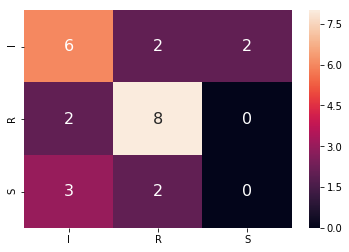

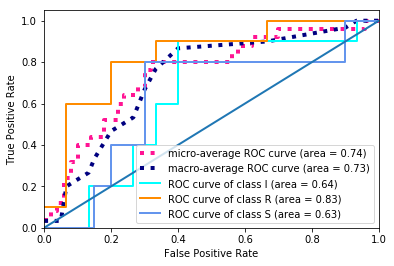


This is the classification report for the eval set:
             precision    recall  f1-score   support

          I       0.55      0.60      0.57        10
          R       0.67      0.80      0.73        10
          S       0.00      0.00      0.00         5

avg / total       0.48      0.56      0.52        25

This is the classification report for the training set:
             precision    recall  f1-score   support

          I       1.00      1.00      1.00        23
          R       1.00      1.00      1.00        23
          S       1.00      1.00      1.00        10

avg / total       1.00      1.00      1.00        56



VotingClassifier(estimators=[('cnn', Pipeline(steps=[('col_extract_cnn', ColumnExtractor(pref='cnn_')), ('cnn_model', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=3000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=No...  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]))],
         n_jobs=1, voting='soft', weights=[2, 1])

In [146]:
#params = [{'voting':['soft']}, {'weights': [[1,2], [2,1], [3,1], [4,1]]}]
params = [{'voting':['soft', 'hard'], 'weights': [[1,2], [2,1],[3,1], [4,1]]}]
m = GridSearchCV(eclf, cv=7, param_grid = params)
utils.do_CV(X,y, m)

In [172]:
mod.classes_

array(['I', 'R', 'S'], dtype=object)

In [125]:
vbow.fit(X_train, y_train).predict(X_test)

array(['R', 'I', 'R', 'R', 'I', 'I', 'R', 'I', 'R', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'R', 'R', 'I', 'I', 'I', 'I', 'R', 'I', 'I'], dtype=object)

In [123]:
y_test

12/5-29-12/4-16-13     I
10/6-21-17/9-22-16     I
35/10-15-15/9-4-14     R
33/8-14-12/1-29-15     I
7b/4-10-12/5-28-15     I
1/10-05-15/10-06-14    I
10/9-22-16/6-21-17     R
12/4-16-13/5-29-12     R
8/2-26-15/3-4-14       R
1/11-21-16/10-05-15    R
12/4-16-13/5-24-14     S
12/4-16-13/3-13-15     S
1/10-06-14/10-05-15    R
26/3-19-15/3-10-16     S
35/9-4-14/10-15-15     I
9/3-23-17/6-20-18      I
9/6-20-18/3-23-17      R
10/11-7-12/9-22-16     I
30/7-19-12/1-19-10     R
35/9-4-14/12-30-16     I
9/3-9-16/3-23-17       S
10/11-7-12/8-13-15     I
7b/5-28-15/4-10-12     R
1/8-16-12/11-20-13     S
16/10-8-13/9-4-12      R
Name: y, dtype: object

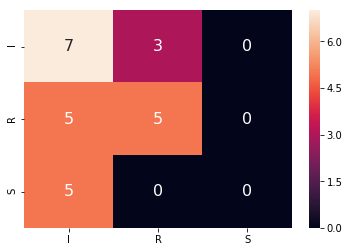

IndexError: too many indices for array

In [120]:
from sklearn.metrics import roc_auc_score
def get_vals(model, X_test, y_test, multi_class=False):
    y_pred = model.predict(X_test)
    utils.plot_confusion_matrix(y_test, y_pred)
    if multi_class == False:
        my_dict = {'I':1, 'SR':-1}
        print("ROC AUC score")
        print(roc_auc_score(np.vectorize(my_dict.get)(y_test), np.vectorize(my_dict.get)(y_pred)))
        utils.plot_roc_binary(y_test, model.predict(X_test))
    else:
        utils.plot_roc_multi(y_test, model.predict(X_test))
    print()
    print("This is the classification report for the eval set:")
    print(classification_report(y_test, y_pred))

    print("This is the classification report for the training set:")
    y_train_pred = model.predict(X_train)
    print(classification_report(y_train, y_train_pred))

get_vals(eclf,X_test, y_test, multi_class=True)

In [112]:
y_test

12/5-29-12/4-16-13     I
10/6-21-17/9-22-16     I
35/10-15-15/9-4-14     R
33/8-14-12/1-29-15     I
7b/4-10-12/5-28-15     I
1/10-05-15/10-06-14    I
10/9-22-16/6-21-17     R
12/4-16-13/5-29-12     R
8/2-26-15/3-4-14       R
1/11-21-16/10-05-15    R
12/4-16-13/5-24-14     S
12/4-16-13/3-13-15     S
1/10-06-14/10-05-15    R
26/3-19-15/3-10-16     S
35/9-4-14/10-15-15     I
9/3-23-17/6-20-18      I
9/6-20-18/3-23-17      R
10/11-7-12/9-22-16     I
30/7-19-12/1-19-10     R
35/9-4-14/12-30-16     I
9/3-9-16/3-23-17       S
10/11-7-12/8-13-15     I
7b/5-28-15/4-10-12     R
1/8-16-12/11-20-13     S
16/10-8-13/9-4-12      R
Name: y, dtype: object

In [82]:


tuned_parameters = [
  {
    'estimator__kernel': ['rbf'],
    'estimator__gamma': [1e-3, 1e-4],
    'estimator__C': [1, 10, 100, 1000]
  },
  {
    'estimator__kernel': ['linear'], 
    'estimator__C': [1, 10, 100, 1000]
  }
]

model_to_set = OneVsRestClassifier(SVC(), n_jobs=-1)
clf = GridSearchCV(model_to_set, tuned_parameters)
clf.fit(X_train, y_train)

NameError: name 'OneVsRestClassifier' is not defined

In [78]:
train_ensemble(train_X,train_y,multiclass=False, cv=None)

# Tuning hyper-parameter



IndexError: too many indices for array

In [148]:
probas = [c.fit(X, y).predict_proba(X) for c in (clf1, clf2, clf3, eclf)]

NameError: name 'clf1' is not defined

In [147]:
# get class probabilities for the first sample in the dataset
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]


# plotting

N = 4  # number of groups
ind = np.arange(N)  # group positions
width = 0.35  # bar width

fig, ax = plt.subplots()

# bars for classifier 1-3
p1 = ax.bar(ind, np.hstack(([class1_1[:-1], [0]])), width,
            color='green', edgecolor='k')
p2 = ax.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), width,
            color='lightgreen', edgecolor='k')

# bars for VotingClassifier
p3 = ax.bar(ind, [0, 0, 0, class1_1[-1]], width,
            color='blue', edgecolor='k')
p4 = ax.bar(ind + width, [0, 0, 0, class2_1[-1]], width,
            color='steelblue', edgecolor='k')

# plot annotations
plt.axvline(2.8, color='k', linestyle='dashed')
ax.set_xticks(ind + width)
ax.set_xticklabels(['LogisticRegression\nweight 1',
                    'GaussianNB\nweight 1',
                    'RandomForestClassifier\nweight 5',
                    'VotingClassifier\n(average probabilities)'],
                   rotation=40,
                   ha='right')
plt.ylim([0, 1])
plt.title('Class probabilities for sample 1 by different classifiers')
plt.legend([p1[0], p2[0]], ['class 1', 'class 2'], loc='upper left')
plt.tight_layout()
plt.show()

NameError: name 'probas' is not defined